# Shift of Hologram

In [110]:
import numpy as np
# Set up matplotlib and use a nicer set of plot parameters
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

In [111]:
# to enlarge the sizes
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (10, 10),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
plt.rcParams.update(params)


In [112]:
from astropy.wcs import WCS
from astropy.io import fits
from astropy import units as u
# from astropy.utils.data import get_pkg_data_filename

In [113]:
u.imperial.enable() 

In [114]:
#from IPython.display import Image
#from pyds9 import *

## Instrument

### Telescope

In [115]:
Tel_Focal_Length=12.6*u.m # m : Focal length of the telescope
Tel_Diameter=0.9*u.m # m : Diameter of the telescope

### Grating

In [116]:
Ronchi_r=400/u.mm # number of lines per mm
Ronchi_a=1./Ronchi_r  # line spacing in meter unit
Ronchi_size=(2.*u.imperial.inch).to(u.mm) # size of Ronchi Grating in meter
Ronchi_N=(Ronchi_size/Ronchi_a).decompose()   # total number of lines (not used)

In [117]:
Ronchi_a

<Quantity 0.0025 mm>

### Filter wheel or Hologram

In [118]:
Filt_D=57.69*u.mm # distance of the filter position wrt CCD plane
Filt_size=(3.*u.imperial.inch).to(u.mm)

### Hologram

In [119]:
wl_ref=600*u.nm

### CCD

In [120]:
NBCCDPIXEL=2048

In [121]:
CCD_size=(NBCCDPIXEL,NBCCDPIXEL)

In [122]:
pixel_size=24*u.micron

In [123]:
angle_per_pixel=((pixel_size/Tel_Focal_Length)*u.rad).to(u.arcsec)

In [124]:
CCD_width=(NBCCDPIXEL*pixel_size).to(u.mm)

In [125]:
CCD_width2=CCD_width/u.mm

# Functions definition

## Physics function

In [126]:
def angle_grating(wavelength,theta_in=0*u.rad,order=1):
    return (order*wavelength/Ronchi_a).decompose()*u.rad+theta_in.to(u.rad)  

In [127]:
def dispersion_shift(wavelength,theta_in=0*u.rad,order=1):
    return Filt_D*np.sin(angle_grating(wavelength,theta_in,order))

In [128]:
def dispersion_shift_pixel(wavelength,theta_in=0*u.rad,order=1):
    return (dispersion_shift(wavelength,theta_in,order)/pixel_size).decompose()

## Utilities

In [129]:
def plot_CCD(image):
    plt.imshow(image,origin='lower',cmap='Greys',interpolation='nearest')
    plt.colorbar()
    plt.grid(color='white', ls='solid',lw=2)
    plt.xlabel('X (pixel)')
    plt.ylabel('Y (pixel)')
    plt.title("CTIO CCD")

In [130]:
def plot_Point(x,y,marksize=5,colorname="red"):
    plt.plot([x], [y], marker='o', markersize=marksize, color=colorname)

In [145]:
def plot_Hologram(dx,dy):
    a=CCD_width/2./u.mm
    plt.plot([-a,a],[-a,-a],'k-')
    plt.plot([-a,a],[a,a],'k-')
    plt.plot([-a,-a],[-a,a],'k-')
    plt.plot([a,a],[-a,a],'k-')
    plot_Point(dx,dy,10,"k")
    plot_Point(dx*(1-Filt_D/Tel_Focal_Length), dy*(1-Filt_D/Tel_Focal_Length),10,"r")  
    shift=dispersion_shift(wl_ref,np.arctan(dx*u.mm/Tel_Focal_Length))/u.mm
    plot_Point(dx*(1-Filt_D/Tel_Focal_Length)+shift, dy*(1-Filt_D/Tel_Focal_Length),10,"b")  
    plt.grid()
    plt.xlabel('X (mm)')
    plt.ylabel('Y (mm)')
    plt.title("CTIO Hologram")

# Analyse

### generate CCD background (for fun)

In [132]:
image_data = np.random.random(CCD_size)

In [133]:
X0=CCD_size[1]/2.
Y0=CCD_size[0]/2.

### Target pixel to put the zeroth order

In [134]:
max_X=785
max_Y=700

In [135]:
DX_pix=max_X-X0
DY_pix=max_Y-Y0

In [136]:
DX=(DX_pix*pixel_size).to(u.mm)
DY=(DY_pix*pixel_size).to(u.mm)

In [137]:
DX,DY

(<Quantity -5.736 mm>, <Quantity -7.776 mm>)

In [138]:
theta_x=(-DX/Tel_Focal_Length).decompose()*u.rad.to(u.arcmin)
theta_y=(-DY/Tel_Focal_Length).decompose()*u.rad.to(u.arcmin)

In [139]:
theta_x

<Quantity 1.5649932918430487>

### Set of wavelengths

In [140]:
colors_set=['violet','blue','green','red','orange','yellow','brown','white']
wavelengths_set =np.array([400.,500.,600.,700.,800.,900.,1000.,1100.])*u.nm
NBRAYS=wavelengths_set.shape[0]

## Pixel shift CCD

In [141]:
points_set=dispersion_shift(wavelengths_set)
pixels_set=dispersion_shift_pixel(wavelengths_set)

In [142]:
points_set

<Quantity [  9.19106734, 11.46123369, 13.71306452, 15.94295737,
            18.14734488, 20.32270052, 22.46554417, 24.57244774] mm>

# Plot

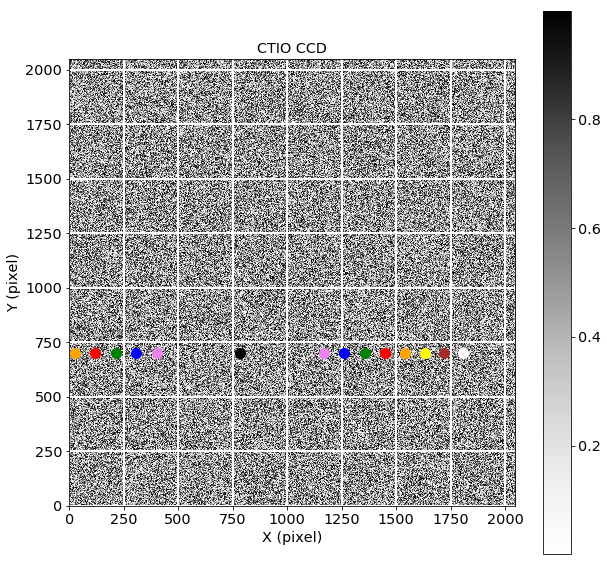

In [143]:
plot_CCD(image_data)
plot_Point(max_X,max_Y,10,"k")

for index in np.arange(0,NBRAYS):
    newX=max_X+pixels_set[index]
    if newX>0 and newX<NBCCDPIXEL:
        plot_Point(newX,max_Y,10,colors_set[index])
    newX=max_X-pixels_set[index]
    if newX>0 and newX<NBCCDPIXEL:
        plot_Point(newX,max_Y,10,colors_set[index])

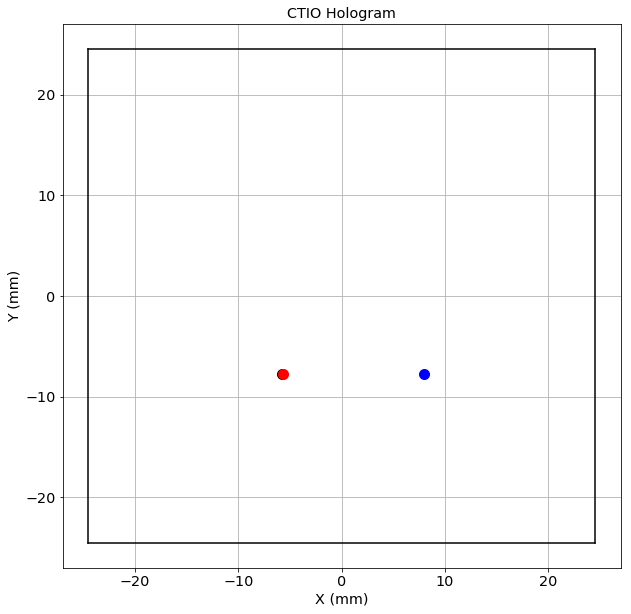

In [146]:
plot_Hologram(DX/u.mm,DY/u.mm)